## set running directory to project source

In [3]:
import os
os.chdir(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src'))
from pkg.utils.code_scraps import add_indy_sweep_tool, \
        use_current_place_point_only, use_current_sub_binders_only, \
        finish_L_shape, set_l_shape_object, ModeSwitcher, double_sweep_motions

from pkg.controller.combined_robot import *
from pkg.project_config import *
from pkg.geometry.builder.scene_builder import SceneBuilder
from pkg.planning.scene import PlanningScene
from pkg.planning.pipeline import PlanningPipeline
from pkg.ui.ui_broker import *
from pkg.planning.constraint.constraint_actor import Gripper2Tool, PlacePlane, SweepFramer, FixtureSlot
from pkg.planning.constraint.constraint_common import MotionConstraint
from pkg.planning.constraint.constraint_subject import AbstractTask, AbstractObject
from pkg.planning.constraint.constraint_subject import SweepLineTask
from pkg.planning.constraint.constraint_subject import SweepFrame
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
from pkg.planning.task.rrt import TaskRRT
from pkg.planning.constraint.constraint_common import sample_redundancy, combine_redundancy
from pkg.planning.sampling.node_sampling import make_state_param_hashable, UniformNodeSampler, PenaltyNodeSampler, GrowingSampler
from pkg.planning.task.custom_rules.sweep_entrance_control import SweepEntranceControlRule
import matplotlib.pyplot as plt
import math
import numpy as np
from collections import defaultdict

DATASET_DIR = os.path.join(os.environ["RNB_PLANNING_DIR"], 'data/sweep_reach')
try_mkdir(DATASET_DIR)

## create scene builder

In [5]:
ROBOT_TYPE = RobotType.indy7
TIMEOUT_MP = 0.5

robot_config = RobotConfig(0, ROBOT_TYPE, ((0.0,0.0,0), (0,0,0)), INDY_IP)

crob = CombinedRobot(robots_on_scene=[robot_config], connection_list=[False])

ROBOT_NAME = robot_config.get_indexed_name()
s_builder = SceneBuilder(None)
# s_builder.reset_reference_coord(ref_name="floor")

connection command:
indy0: False


## make geometry scene

In [3]:
BASE_LINK = "base_link"
EE_NAME = "ee_point"
gscene = s_builder.create_gscene(crob, start_rviz=True)

floor = gscene.create_safe(GEOTYPE.BOX, "floor", BASE_LINK, (3,3,0.01), (0,0,0), 
                           rpy=(0,0,0), color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=False)
gtems = s_builder.add_robot_geometries(color=(0,1,0,0.5), display=True, collision=True)
# ee_point.draw_traj_coords([[0]*6])

Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker


## init planning pipeline

In [4]:
pscene = PlanningScene(gscene, combined_robot=crob)
TIP_LINK = pscene.robot_chain_dict[ROBOT_NAME]["tip_link"]
ee_point = gscene.create_safe(GEOTYPE.SPHERE, EE_NAME, TIP_LINK, (0.01,)*3, 
                              center=(0,0,0), rpy=(0,0,0), 
                              color=(0.8,0.2,0.2,0.8), display=True, fixed=True, collision=False)

ppline = PlanningPipeline(pscene)

mplan = MoveitPlanner(pscene)
mplan.update_gscene()
ppline.set_motion_planner(mplan)


# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production


## Set Parameters

In [5]:
# # back-backward sweep
# DATASET_PATH = os.path.join(DATASET_DIR, ROBOT_TYPE.name+'.npy')
# R_be = Rot_rpy([np.pi, np.pi/2, 0])
# SWEEP_AXIS = "Y"
# X_range = (-1, -0.3)
# Y_range = (-1, 1)
# Z_range = (0.0, 0.7)
# X_step = 0.02
# Y_step = 0.01
# Z_step = 0.02

# # back-upward sweep
# DATASET_PATH = os.path.join(DATASET_DIR, ROBOT_TYPE.name+'-up.npy')
# R_be = Rot_rpy([np.pi, np.pi, 0])
# SWEEP_AXIS = "Y"
# X_range = (-0.8, -0.2)
# Y_range = (-1, 1)
# Z_range = (0.0, 0.3)
# X_step = 0.02
# Y_step = 0.01
# Z_step = 0.02

# back-downward sweep
DATASET_PATH = os.path.join(DATASET_DIR, ROBOT_TYPE.name+'-down.npy')
R_be = Rot_rpy([np.pi, 0, np.pi])
SWEEP_AXIS = "Y"
X_range = (-0.8, -0.2)
Y_range = (-1, 1)
Z_range = (-0.3, 0.8)
X_step = 0.02
Y_step = 0.01
Z_step = 0.02


VISUALIZE = False
VERBOSE = True
N_try = 3
SWEEP_DIV = 10

# # dummy tool coord
# gscene.add_highlight_axis("tool", "coord", link_name="indy0_tcp", 
#                           center=(0.1,0,0.2), orientation_mat=Rot_rpy((0,0,np.pi)))

   Use a production WSGI server instead.
 * Debug mode: off


## Scan

In [6]:
gtimer = GlobalTimer.instance()
gtimer.reset()

X_DIR, Y_DIR, Z_DIR = np.identity(3, dtype=np.int)
SWEEP_AX_IDX = "xyz".find(SWEEP_AXIS.lower())
SWEEP_DIR = [X_DIR, Y_DIR, Z_DIR][SWEEP_AX_IDX]
RANGE_STEPS_REF = [(X_range, X_step, X_DIR), (Y_range, Y_step, Y_DIR), (Z_range, Z_step, Z_DIR)]
RANGE_STEPS = np.array(RANGE_STEPS_REF)[np.where(np.logical_not(SWEEP_DIR))]
RANGE1, STEP1, DIR1 = RANGE_STEPS[0]
RANGE2, STEP2, DIR2 = RANGE_STEPS[1]
RANGEX, STEPX, DIRX = RANGE_STEPS_REF[SWEEP_AX_IDX]
STEP_SWEEP = float(RANGEX[1] - RANGEX[0])/SWEEP_DIV

range_list_dict = {}
STEPS_1 = np.round(np.arange(RANGE1[0], RANGE1[1]+STEP1, STEP1), 4)
STEPS_2 = np.round(np.arange(RANGE2[0], RANGE2[1]+STEP2, STEP2), 4)
STEPS_X = np.round([0] + np.arange(RANGEX[0], RANGEX[1]-1e-3, STEP_SWEEP)[1:].tolist(), 4)
LEN_1, LEN_2 = len(STEPS_1), len(STEPS_2)
count = 0
LEN_ALL = LEN_1*LEN_2
gtimer.tic("test")
for i_p1, pos1 in enumerate(STEPS_1):
    for i_p2, pos2 in enumerate(STEPS_2):
        count += 1
        with gtimer.block("loop"):
            pos0 = np.multiply(pos1, DIR1) + np.multiply(pos2, DIR2)
            key = tuple(np.round(pos0, 4))
            print("========= {} ({}/{})=========".format(key, count, LEN_ALL))
            T_be = SE3(R_be, pos0)
            for _ in range(N_try):
                traj, success = mplan.planner.plan_py(
                    ROBOT_NAME, TIP_LINK, np.concatenate(T2xyzquat(T_be)), BASE_LINK, np.zeros(gscene.joint_num), 
                    timeout=TIMEOUT_MP)

                if success:
                    break
            if not success:
                continue
            p2p_list = []
            for i_px, posx in enumerate(STEPS_X):
                pos_sweep = np.multiply(posx, DIRX)
                pos = pos0 + pos_sweep
                T_be = SE3(R_be, pos)
                if i_px > 0: # already done for 0
                    if abs(posx) < 1e-4: # already done for 0 at 0 index
                        continue
                    traj, success = mplan.planner.plan_py(
                        ROBOT_NAME, TIP_LINK, np.concatenate(T2xyzquat(T_be)), BASE_LINK, np.zeros(gscene.joint_num), 
                        timeout=TIMEOUT_MP)
                if not success:
                    continue
                Q0 = traj[-1]
                if VISUALIZE:
                    gscene.show_pose(Q0)

                pos_tar = np.multiply(RANGEX[0], DIRX)
                dP_tar = pos_tar - pos_sweep
                Traj_down, success = get_sweep_traj(mplan, ee_point, dP_tar, Q0, DP=STEPX, ERROR_CUT=0.01, VISUALIZE=VISUALIZE, VERBOSE=VERBOSE)
                if len(Traj_down)==0:
                    continue
                Qdown = Traj_down[-1]

                pos_tar = np.multiply(RANGEX[1], DIRX)
                dP_tar = pos_tar - pos_sweep
                Traj_up, success = get_sweep_traj(mplan, ee_point, dP_tar, Q0, DP=STEPX, ERROR_CUT=0.01, VISUALIZE=VISUALIZE, VERBOSE=VERBOSE)
                if len(Traj_up)==0:
                    continue
                Qup = Traj_up[-1]

                p0 = ee_point.get_tf(list2dict(Q0, gscene.joint_names))[SWEEP_AX_IDX,3]
                pdown = ee_point.get_tf(list2dict(Qdown, gscene.joint_names))[SWEEP_AX_IDX,3]
                pup = ee_point.get_tf(list2dict(Qup, gscene.joint_names))[SWEEP_AX_IDX,3]
                p2p = (pdown, pup)
                if np.multiply(*np.sign(p2p))<0:
                    p2p_list.append(p2p)
            range_list_dict[key] = np.array(p2p_list)
    elapsed = gtimer.toc("test")/1000
    print(gtimer)
    print("=============================================")
    print("=============== {} / {} s===================".format(int(elapsed), int(elapsed/count*LEN_ALL)))

    print("=============================================")
    
best_range_dict = {}
for k,v in range_list_dict.items():
    if len(v)>0:
        i_max = np.argmax(v[:,1]-v[:,0])
        best_range_dict[k] = v[i_max]
    else:
        best_range_dict[k] = (0,0)
# np.save(DATASET_PATH, {"best_range_dict": best_range_dict, "range_list_dict": range_list_dict})

========= (-0.8, -0.0, -0.3) (1/1767)=========
========= (-0.8, -0.0, -0.28) (2/1767)=========
========= (-0.8, -0.0, -0.26) (3/1767)=========
========= (-0.8, -0.0, -0.24) (4/1767)=========
========= (-0.8, -0.0, -0.22) (5/1767)=========
========= (-0.8, -0.0, -0.2) (6/1767)=========
========= (-0.8, -0.0, -0.18) (7/1767)=========
========= (-0.8, -0.0, -0.16) (8/1767)=========
========= (-0.8, -0.0, -0.14) (9/1767)=========
========= (-0.8, -0.0, -0.12) (10/1767)=========
========= (-0.8, -0.0, -0.1) (11/1767)=========
========= (-0.8, -0.0, -0.08) (12/1767)=========
========= (-0.8, -0.0, -0.06) (13/1767)=========
========= (-0.8, -0.0, -0.04) (14/1767)=========
joint max
joint max
========= (-0.8, -0.0, -0.02) (15/1767)=========
joint max
joint max
========= (-0.8, 0.0, 0.0) (16/1767)=========
joint max
joint max
========= (-0.8, 0.0, 0.02) (17/1767)=========
joint max
joint max
========= (-0.8, 0.0, 0.04) (18/1767)=========
joint max
joint max
========= (-0.8, 0.0, 0.06) (19/1767)

joint max
joint max
joint max
joint max
joint max
========= (-0.76, 0.0, 0.02) (131/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.76, 0.0, 0.04) (132/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.76, 0.0, 0.06) (133/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.76, 0.0, 0.08) (134/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.76, 0.0, 0.1) (135/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.76, 0.0, 0.12) (136/1767)=========
joint max
singular
joint max
joint max
joint max
joint max
========= (-0.76, 0.0, 0.14) (137/1767)=========
singular
singular
singular
singular
singular
singular
========= (-0.76, 0.0, 0.16) (138/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.76, 0.0, 0.18) (139/1767)=========
singular
singular
singular
singular
s

joint max
joint max
joint max
joint max
========= (-0.72, -0.0, -0.12) (238/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.72, -0.0, -0.1) (239/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.72, -0.0, -0.08) (240/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.72, -0.0, -0.06) (241/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.72, -0.0, -0.04) (242/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.72, -0.0, -0.02) (243/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.72, 0.0, 0.0) (244/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.72, 0.0, 0.02) (245/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.72, 0.0, 0.04) (246/1767)=========
joint max
joint max
joint max

singular
singular
singular
singular
singular
========= (-0.7, 0.0, 0.44) (323/1767)=========
singular
singular
singular
singular
singular
singular
========= (-0.7, 0.0, 0.46) (324/1767)=========
singular
singular
========= (-0.7, 0.0, 0.48) (325/1767)=========
singular
singular
========= (-0.7, 0.0, 0.5) (326/1767)=========
singular
singular
========= (-0.7, 0.0, 0.52) (327/1767)=========
========= (-0.7, 0.0, 0.54) (328/1767)=========
========= (-0.7, 0.0, 0.56) (329/1767)=========
========= (-0.7, 0.0, 0.58) (330/1767)=========
========= (-0.7, 0.0, 0.6) (331/1767)=========
========= (-0.7, 0.0, 0.62) (332/1767)=========
========= (-0.7, 0.0, 0.64) (333/1767)=========
========= (-0.7, 0.0, 0.66) (334/1767)=========
========= (-0.7, 0.0, 0.68) (335/1767)=========
========= (-0.7, 0.0, 0.7) (336/1767)=========
========= (-0.7, 0.0, 0.72) (337/1767)=========
========= (-0.7, 0.0, 0.74) (338/1767)=========
========= (-0.7, 0.0, 0.76) (339/1767)=========
========= (-0.7, 0.0, 0.78) (340/1

joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.66, -0.0, -0.06) (412/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.66, -0.0, -0.04) (413/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.66, -0.0, -0.02) (414/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.66, 0.0, 0.0) (415/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.66, 0.0, 0.02) (416/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.66, 0.0, 0.04) (417/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
========= (

joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.64, 0.0, 0.22) (483/1767)=========
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
========= (-0.64, 0.0, 0.24) (484/1767)=========
joint max
joint max
joint max
singular
joint max
joint max
joint max
singular
joint max
error off
========= (-0.64, 0.0, 0.26) (485/1767)=========
singular
joint max
joint max
joint max
joint max
joint max
singular
joint max
joint max
joint max
========= (-0.64, 0.0, 0.28) (486/1767)=========
error off
singular
singular
singular
singular
error off
singular
singular
singular
singular
========= (-0.64, 0.0, 0.3) (487/1767)=========
singular
singular
joint max
singular
joint max
joint max
singular
joint max
joint max
joint max
========= (-0.64, 0.0, 0.32) (488/1767)=========
singular
singular
singular
joint max
joint max
singular
singular
joint max
joint max
joint max
========= (-0.64, 0.0, 0.34) (489/1767

singular
singular
========= (-0.62, 0.0, 0.46) (552/1767)=========
singular
singular
singular
singular
singular
singular
========= (-0.62, 0.0, 0.48) (553/1767)=========
joint max
singular
singular
joint max
error off
singular
========= (-0.62, 0.0, 0.5) (554/1767)=========
singular
singular
singular
singular
singular
singular
========= (-0.62, 0.0, 0.52) (555/1767)=========
error off
singular
error off
singular
singular
error off
========= (-0.62, 0.0, 0.54) (556/1767)=========
singular
singular
singular
singular
singular
singular
========= (-0.62, 0.0, 0.56) (557/1767)=========
singular
singular
error off
singular
singular
singular
========= (-0.62, 0.0, 0.58) (558/1767)=========
singular
error off
========= (-0.62, 0.0, 0.6) (559/1767)=========
singular
singular
========= (-0.62, 0.0, 0.62) (560/1767)=========
========= (-0.62, 0.0, 0.64) (561/1767)=========
========= (-0.62, 0.0, 0.66) (562/1767)=========
========= (-0.62, 0.0, 0.68) (563/1767)=========
========= (-0.62, 0.0, 0.7) 

========= (-0.58, -0.0, -0.28) (629/1767)=========
========= (-0.58, -0.0, -0.26) (630/1767)=========
joint max
joint max
singular
singular
singular
singular
========= (-0.58, -0.0, -0.24) (631/1767)=========
joint max
joint max
joint max
joint max
joint max
singular
========= (-0.58, -0.0, -0.22) (632/1767)=========
singular
singular
singular
singular
joint max
joint max
========= (-0.58, -0.0, -0.2) (633/1767)=========
singular
singular
singular
singular
joint max
joint max
========= (-0.58, -0.0, -0.18) (634/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
singular
singular
joint max
joint max
========= (-0.58, -0.0, -0.16) (635/1767)=========
singular
singular
joint max
joint max
error off
singular
singular
singular
joint max
joint max
========= (-0.58, -0.0, -0.14) (636/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.58, -0.0, -0.12) (637/1767)=========
singular
singular
join

joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.56, -0.0, -0.06) (697/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.56, -0.0, -0.04) (698/1767)=========
singular
singular
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.56, -0.0, -0.02) (699/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.56, 0.0, 0.0) (700/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.56, 0.0, 0.02) (701/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.56, 0.0, 0.04) (702/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
===

joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.54, 0.0, 0.06) (760/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.54, 0.0, 0.08) (761/1767)=========
joint max
joint max
joint min
joint min
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.54, 0.0, 0.1) (762/1767)=========
joint max
joint max
joint min
joint min
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.54, 0.0, 0.12) (763/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.54, 0.0, 0.14) (764/1767)=========
singular
singular
singular
joint min
singular
singular
singular
si

singular
singular
joint max
singular
singular
singular
singular
singular
singular
========= (-0.52, 0.0, 0.1) (819/1767)=========
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
========= (-0.52, 0.0, 0.12) (820/1767)=========
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
========= (-0.52, 0.0, 0.14) (821/1767)=========
singular
singular
error off
joint max
singular
joint max
joint max
singular
singular
joint max
singular
joint max
joint max
singular
========= (-0.52, 0.0, 0.16) (822/1767)=========
joint max
joint max
joint max
collision
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.52, 0.0, 0.18) (823/1767)=========
joint max
joint max
joint max
singular
joint max
singular
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
========= (

joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.5, 0.0, 0.12) (877/1767)=========
joint max
joint max
joint min
joint min
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.5, 0.0, 0.14) (878/1767)=========
joint max
joint max
joint min
joint min
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.5, 0.0, 0.16) (879/1767)=========
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
========= (-0.5, 0.0, 0.18) (880/1767)=========
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
========= (-0.5, 0.0, 0.2) (881/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max

singular
singular
joint min
joint min
singular
joint max
joint max
singular
joint max
singular
joint max
singular
joint max
joint max
========= (-0.48, 0.0, 0.12) (934/1767)=========
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
========= (-0.48, 0.0, 0.14) (935/1767)=========
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
========= (-0.48, 0.0, 0.16) (936/1767)=========
singular
singular
error off
singular
singular
singular
error off
singular
singular
error off
singular
singular
singular
singular
========= (-0.48, 0.0, 0.18) (937/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.48, 0.0, 0.2) (938/1767)=========
singular
singular
singular
joint min
singular
singular
singular
singular
singular
singular
singular
s

joint max
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.46, 0.0, 0.08) (989/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.46, 0.0, 0.1) (990/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.46, 0.0, 0.12) (991/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.46, 0.0, 0.14) (992/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.46, 0.0, 0.16) (993/1767)=========
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular


========= (-0.44, 0.0, 0.02) (1043/1767)=========
singular
singular
joint min
joint min
joint min
joint min
singular
singular
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.44, 0.0, 0.04) (1044/1767)=========
joint max
joint max
joint max
joint max
joint min
joint min
singular
singular
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.44, 0.0, 0.06) (1045/1767)=========
singular
singular
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.44, 0.0, 0.08) (1046/1767)=========
singular
singular
singular
joint max
singular
singular
singular
singular
singular
singular
singular
singular
singular
joint max
========= (-0.44, 0.0, 0.1) (1047/1767)=========
singular
singular
singular
singular
singular
joint min
singular
singular
singular
singular
singular
singular
singular
singular
========= (-0.44, 0.0, 0.12) (1048/1767)=========
joint max
joint max
error off
join

singular
joint max
singular
singular
singular
joint max
joint max
singular
joint max
========= (-0.42, -0.0, -0.04) (1097/1767)=========
joint max
joint max
joint max
joint max
joint max
singular
joint max
singular
joint max
singular
joint max
joint max
joint max
joint max
========= (-0.42, -0.0, -0.02) (1098/1767)=========
singular
singular
joint min
joint min
joint max
singular
singular
singular
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.42, 0.0, 0.0) (1099/1767)=========
singular
singular
joint min
joint min
joint max
joint max
singular
singular
singular
singular
joint max
joint max
joint max
joint max
========= (-0.42, 0.0, 0.02) (1100/1767)=========
joint max
joint max
joint max
joint max
joint max
joint max
singular
singular
singular
singular
joint max
joint max
joint max
joint max
========= (-0.42, 0.0, 0.04) (1101/1767)=========
joint max
joint max
joint min
joint min
joint max
joint max
joint max
joint max
singular
singular
joint max
joint max
jo

joint max
joint max
joint max
singular
singular
singular
joint max
========= (-0.4, -0.0, -0.12) (1150/1767)=========
singular
singular
joint max
joint max
joint max
joint max
singular
singular
singular
singular
singular
singular
singular
joint max
========= (-0.4, -0.0, -0.1) (1151/1767)=========
singular
singular
joint max
singular
joint max
singular
joint max
joint max
singular
error off
singular
singular
singular
joint max
========= (-0.4, -0.0, -0.08) (1152/1767)=========
singular
singular
joint max
singular
joint min
joint min
singular
singular
joint max
singular
error off
singular
joint max
========= (-0.4, -0.0, -0.06) (1153/1767)=========
singular
singular
joint min
joint min
joint max
singular
singular
joint max
joint max
singular
singular
singular
joint max
========= (-0.4, -0.0, -0.04) (1154/1767)=========
singular
singular
joint min
joint min
joint min
joint min
singular
singular
joint max
joint max
singular
joint max
singular
joint max
========= (-0.4, -0.0, -0.02) (1155/

singular
joint max
singular
singular
singular
joint min
joint min
singular
joint max
========= (-0.38, -0.0, -0.22) (1202/1767)=========
singular
singular
joint min
singular
joint max
singular
joint max
joint min
joint max
joint max
========= (-0.38, -0.0, -0.2) (1203/1767)=========
singular
singular
singular
singular
singular
singular
joint min
joint min
singular
singular
========= (-0.38, -0.0, -0.18) (1204/1767)=========
joint max
singular
joint max
singular
joint max
singular
joint max
singular
singular
singular
joint max
joint max
singular
joint max
========= (-0.38, -0.0, -0.16) (1205/1767)=========
singular
singular
joint max
singular
joint max
singular
joint min
joint min
singular
singular
joint max
joint max
singular
joint max
========= (-0.38, -0.0, -0.14) (1206/1767)=========
joint max
joint min
joint max
singular
joint min
joint min
joint max
singular
joint max
joint min
singular
joint max
singular
joint max
========= (-0.38, -0.0, -0.12) (1207/1767)=========
singular
singu

========= (-0.38, 0.0, 0.72) (1249/1767)=========
singular
singular
singular
singular
joint max
singular
========= (-0.38, 0.0, 0.74) (1250/1767)=========
error off
singular
error off
joint max
error off
error off
========= (-0.38, 0.0, 0.76) (1251/1767)=========
singular
singular
singular
singular
singular
singular
========= (-0.38, 0.0, 0.78) (1252/1767)=========
singular
singular
========= (-0.38, 0.0, 0.8) (1253/1767)=========
========= (-0.38, 0.0, 0.82) (1254/1767)=========
test: 	44713722.2 ms/22 = 2032441.9 ms (134295.382/4117511.077)
loop: 	4117446.4 ms/1254 = 3283.5 ms (1535.822/4671.851)

=============== 4117 / 5801 s===================
========= (-0.36, -0.0, -0.3) (1255/1767)=========
========= (-0.36, -0.0, -0.28) (1256/1767)=========
========= (-0.36, -0.0, -0.26) (1257/1767)=========
joint max
joint max
joint max
singular
singular
singular
joint min
joint min
singular
singular
========= (-0.36, -0.0, -0.24) (1258/1767)=========
joint min
joint min
joint max
singular
joi

joint min
singular
singular
joint min
joint min
singular
singular
joint max
singular
========= (-0.36, 0.0, 0.58) (1299/1767)=========
joint min
joint min
singular
singular
joint min
joint min
singular
singular
singular
singular
========= (-0.36, 0.0, 0.6) (1300/1767)=========
singular
singular
singular
singular
singular
singular
singular
singular
joint max
singular
========= (-0.36, 0.0, 0.62) (1301/1767)=========
singular
singular
singular
joint max
singular
singular
singular
singular
singular
singular
========= (-0.36, 0.0, 0.64) (1302/1767)=========
joint min
joint min
singular
joint max
error off
joint max
joint max
singular
joint max
joint max
========= (-0.36, 0.0, 0.66) (1303/1767)=========
joint min
joint min
singular
singular
singular
singular
singular
singular
singular
singular
========= (-0.36, 0.0, 0.68) (1304/1767)=========
joint min
joint min
error off
singular
error off
joint max
joint max
joint max
error off
error off
========= (-0.36, 0.0, 0.7) (1305/1767)=========
jo

joint max
error off
joint max
joint max
joint max
error off
error off
========= (-0.34, 0.0, 0.44) (1349/1767)=========
singular
singular
singular
joint min
singular
singular
error off
singular
singular
singular
joint max
singular
error off
error off
========= (-0.34, 0.0, 0.46) (1350/1767)=========
singular
singular
error off
joint min
error off
joint max
joint min
joint min
error off
singular
joint max
singular
joint max
error off
========= (-0.34, 0.0, 0.48) (1351/1767)=========
joint min
joint min
error off
joint max
singular
singular
singular
singular
joint min
joint min
collision
error off
joint max
error off
========= (-0.34, 0.0, 0.5) (1352/1767)=========
singular
singular
singular
singular
singular
joint min
singular
singular
joint min
joint min
singular
singular
singular
singular
========= (-0.34, 0.0, 0.52) (1353/1767)=========
singular
joint min
error off
singular
joint min
joint min
singular
error off
error off
error off
========= (-0.34, 0.0, 0.54) (1354/1767)=========
jo

joint max
joint max
joint max
joint max
joint min
joint min
joint max
joint max
singular
joint max
joint max
singular
joint max
joint max
========= (-0.32, 0.0, 0.32) (1400/1767)=========
singular
singular
singular
joint min
singular
joint min
singular
singular
singular
singular
singular
singular
singular
singular
========= (-0.32, 0.0, 0.34) (1401/1767)=========
error off
singular
singular
joint min
singular
singular
error off
error off
error off
singular
singular
error off
error off
error off
========= (-0.32, 0.0, 0.36) (1402/1767)=========
singular
joint max
error off
singular
error off
joint min
joint max
singular
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.32, 0.0, 0.38) (1403/1767)=========
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
singular
========= (-0.32, 0.0, 0.4) (1404/1767)=========
joint max
singular
joint min
joint min
joint min
joint min
joint min
joint min
joint max

joint max
joint max
joint max
joint max
joint min
joint min
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.3, 0.0, 0.18) (1450/1767)=========
joint max
joint max
joint max
joint max
joint min
joint min
joint min
joint min
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.3, 0.0, 0.2) (1451/1767)=========
singular
singular
singular
singular
singular
joint min
singular
joint min
singular
singular
singular
singular
singular
singular
========= (-0.3, 0.0, 0.22) (1452/1767)=========
joint max
joint min
error off
joint max
joint min
joint min
error off
singular
singular
joint max
joint max
joint max
singular
error off
========= (-0.3, 0.0, 0.24) (1453/1767)=========
singular
joint max
joint min
joint min
joint max
singular
singular
joint max
singular
singular
singular
joint max
singular
joint max
========= (-0.3, 0.0, 0.26) (1454/1767)=========
joint max
joint max
singular
singular
singular
joint max
singular
joint max
singular
joint max
joi

singular
joint max
========= (-0.28, 0.0, 0.02) (1499/1767)=========
singular
singular
joint max
singular
joint min
singular
singular
singular
joint min
joint min
singular
joint max
singular
joint max
========= (-0.28, 0.0, 0.04) (1500/1767)=========
joint max
singular
joint max
singular
joint min
singular
singular
joint max
joint max
joint max
singular
joint max
singular
joint max
========= (-0.28, 0.0, 0.06) (1501/1767)=========
joint max
joint min
joint min
singular
joint max
singular
joint min
joint min
joint max
singular
singular
joint max
joint max
joint max
========= (-0.28, 0.0, 0.08) (1502/1767)=========
joint max
joint max
joint max
singular
joint max
joint max
joint max
joint max
singular
singular
singular
joint max
joint max
joint max
========= (-0.28, 0.0, 0.1) (1503/1767)=========
singular
singular
joint min
singular
joint max
singular
joint max
singular
singular
singular
singular
joint max
singular
joint max
========= (-0.28, 0.0, 0.12) (1504/1767)=========
joint max
joi

joint max
joint min
joint min
singular
singular
joint max
singular
joint min
collision
singular
joint max
singular
singular
joint max
========= (-0.26, -0.0, -0.08) (1551/1767)=========
singular
joint max
joint max
singular
singular
singular
singular
singular
singular
singular
singular
joint max
singular
joint max
========= (-0.26, -0.0, -0.06) (1552/1767)=========
singular
joint max
joint min
singular
singular
singular
singular
singular
joint max
joint min
singular
singular
singular
joint max
========= (-0.26, -0.0, -0.04) (1553/1767)=========
joint max
singular
joint max
singular
joint max
joint max
singular
singular
joint max
joint max
joint min
joint max
singular
joint max
========= (-0.26, -0.0, -0.02) (1554/1767)=========
singular
singular
joint min
singular
singular
singular
joint min
joint min
joint max
singular
singular
joint max
singular
joint max
========= (-0.26, 0.0, 0.0) (1555/1767)=========
joint max
singular
joint min
singular
joint min
joint min
joint min
joint min
err

========= (-0.24, -0.0, -0.26) (1599/1767)=========
========= (-0.24, -0.0, -0.24) (1600/1767)=========
========= (-0.24, -0.0, -0.22) (1601/1767)=========
========= (-0.24, -0.0, -0.2) (1602/1767)=========
========= (-0.24, -0.0, -0.18) (1603/1767)=========
========= (-0.24, -0.0, -0.16) (1604/1767)=========
========= (-0.24, -0.0, -0.14) (1605/1767)=========
========= (-0.24, -0.0, -0.12) (1606/1767)=========
joint max
joint min
joint min
singular
joint max
singular
joint max
joint min
singular
singular
singular
singular
singular
joint max
========= (-0.24, -0.0, -0.1) (1607/1767)=========
singular
singular
joint min
singular
joint max
singular
singular
joint max
joint max
joint max
joint max
singular
singular
joint max
========= (-0.24, -0.0, -0.08) (1608/1767)=========
joint max
singular
joint min
singular
singular
joint min
singular
joint min
joint max
joint min
joint max
singular
singular
joint max
========= (-0.24, -0.0, -0.06) (1609/1767)=========
singular
singular
joint min
si

error off
joint max
joint max
singular
test: 	79143939.5 ms/29 = 2729101.4 ms (134295.382/5500854.95)
loop: 	5500769.3 ms/1653 = 3327.7 ms (1535.822/4812.592)

=============== 5500 / 5880 s===================
========= (-0.22, -0.0, -0.3) (1654/1767)=========
========= (-0.22, -0.0, -0.28) (1655/1767)=========
========= (-0.22, -0.0, -0.26) (1656/1767)=========
========= (-0.22, -0.0, -0.24) (1657/1767)=========
========= (-0.22, -0.0, -0.22) (1658/1767)=========
========= (-0.22, -0.0, -0.2) (1659/1767)=========
========= (-0.22, -0.0, -0.18) (1660/1767)=========
========= (-0.22, -0.0, -0.16) (1661/1767)=========
========= (-0.22, -0.0, -0.14) (1662/1767)=========
========= (-0.22, -0.0, -0.12) (1663/1767)=========
========= (-0.22, -0.0, -0.1) (1664/1767)=========
========= (-0.22, -0.0, -0.08) (1665/1767)=========
========= (-0.22, -0.0, -0.06) (1666/1767)=========
========= (-0.22, -0.0, -0.04) (1667/1767)=========
========= (-0.22, -0.0, -0.02) (1668/1767)=========
========= (-0.

========= (-0.2, 0.0, 0.42) (1747/1767)=========
joint min
joint min
error off
joint min
joint max
collision
joint max
joint max
singular
singular
error off
collision
singular
error off
========= (-0.2, 0.0, 0.44) (1748/1767)=========
error off
error off
error off
joint min
joint min
collision
joint max
joint max
error off
error off
joint max
joint max
singular
error off
========= (-0.2, 0.0, 0.46) (1749/1767)=========
singular
singular
singular
singular
joint min
collision
singular
singular
singular
singular
collision
joint min
singular
singular
========= (-0.2, 0.0, 0.48) (1750/1767)=========
singular
joint min
singular
joint min
joint min
collision
joint min
collision
singular
singular
singular
singular
singular
singular
========= (-0.2, 0.0, 0.5) (1751/1767)=========
joint min
joint min
error off
joint max
joint max
joint min
error off
joint max
joint min
joint min
joint min
joint min
error off
error off
========= (-0.2, 0.0, 0.52) (1752/1767)=========
joint min
joint min
error off

In [7]:
np.save(DATASET_PATH, {"best_range_dict": best_range_dict, "range_list_dict": range_list_dict})

## plot ranges

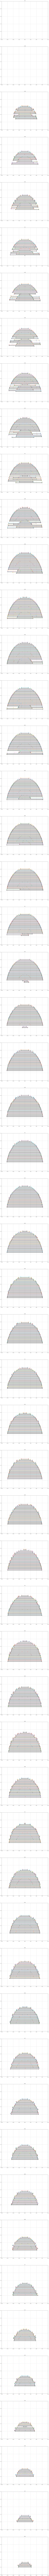

In [8]:
plt.figure(figsize=(15,15*LEN_2))
for i_h, height_plot in enumerate(STEPS_2):
    plt.subplot(LEN_2, 1, i_h+1)
    plt.title(height_plot)
    for k,v in range_list_dict.items():
        if round(k[2], 4)==round(height_plot, 4):
            for vv in v:
                plt.plot(vv, [-k[0]+0.02, -k[0]+0.02], '-o', linewidth=1)
            plt.plot(best_range_dict[k], [-k[0], -k[0]], '-ks', linewidth=3)
    plt.axis([-1,1,0,1])
    plt.grid()

## Read and plot dataset

In [6]:
DIRECTION = "-down"
DATASET_PATH = os.path.join(DATASET_DIR, ROBOT_TYPE.name+DIRECTION+'.npy')

In [7]:
dataset_read = np.reshape(np.load(DATASET_PATH, allow_pickle=True), (1,))[0]
range_list_dict = dataset_read['range_list_dict']
best_range_dict = dataset_read['best_range_dict']

## Save min/max points csv

In [8]:
SWEEP_VEC = [0,1,0]
min_points = []
max_points = []
for k,v in best_range_dict.items():
    min_points.append(tuple(np.add(k, np.multiply(v[0], SWEEP_VEC))))
    max_points.append(tuple(np.add(k, np.multiply(v[1], SWEEP_VEC))))
min_points = sorted(min_points, key=lambda x: (x[2], x[0], x[1]))
max_points = sorted(max_points, key=lambda x: (x[2], x[0], x[1]))
np.savetxt(os.path.join(DATASET_DIR, ROBOT_TYPE.name+DIRECTION+'-min.csv'), min_points, delimiter=",")
np.savetxt(os.path.join(DATASET_DIR, ROBOT_TYPE.name+DIRECTION+'-max.csv'), max_points, delimiter=",")

In [16]:
# DATASET_PATH_BAK1 = os.path.join(DATASET_DIR+"_bak", ROBOT_TYPE.name+'-up.npy')
# DATASET_PATH_BAK2 = os.path.join(DATASET_DIR+"_bak2", ROBOT_TYPE.name+'-up.npy')
# dataset_read_bak1 = np.reshape(np.load(DATASET_PATH_BAK1, allow_pickle=True), (1,))[0]
# dataset_read_bak2 = np.reshape(np.load(DATASET_PATH_BAK2, allow_pickle=True), (1,))[0]
# for k, v in dataset_read_bak1.items():
#     v.update(dataset_read_bak2[k])
# np.save(DATASET_PATH, dataset_read_bak1)